In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
import sys
import os
curruser = os.environ.get('USER')
# sys.path.insert(0, '/home/{}/python36-libs/lib/python3.6/site-packages/'.format(curruser))
sys.path.insert(0, '/home/{}/scripts/pyutils/pretty-print-confusion-matrix'.format(curruser)) 

In [24]:
import argparse
import torch
import pandas as pd
import numpy as np
from pathlib import Path
import os
from src import utils
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from confusion_matrix_pretty_print import pretty_plot_confusion_matrix, \
                                          plot_confusion_matrix_from_data, print_confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from tqdm import tqdm

%matplotlib inline

In [6]:
torch.__version__

'1.5.0+cu101'

In [7]:
use_cuda = torch.cuda.is_available()

def predict(args):
    model = torch.load(args.model)
    processed_input = utils.preprocess_input(args)
    processed_input = torch.tensor(processed_input)
#     processed_input = processed_input.unsqueeze(0)
    if use_cuda:
        processed_input = processed_input.to('cuda')
        model = model.to('cuda')
    prediction = model(processed_input)
    probabilities = F.softmax(prediction, dim=1)
    proba = probabilities.cpu().detach().numpy()
    pred_cls  = np.argmax(proba,axis=-1)
    return pred_cls

### Load OOB dataframe

In [8]:
csvpath = Path.joinpath(Path(os.getcwd()),'data/dnaseg/csv','DnaSeg4ValwLabels.csv')
df = pd.read_csv(csvpath, encoding='utf8',sep=';')

In [9]:
df.head()

,seq,label
0,GTGAAGTCCTCCAGATTCCATTTATCACAGCAACCCTTGCATAATG...,0
1,AAGTTATTACCAAAAAATGGCATTTTTGAGGAGAAATAGCCCAATT...,0
2,CCTTTTCTTCCAATACTATTGAGGCTCACAGTCAGCTCATGTAGAC...,0
3,GGGAAGCAGTGTTGGAGGTGGCAGTGGGAAACCCTTTCAATGGAAA...,0
4,GGCGGGAGCATGATTCTGGTGGCCGAGAGGGGCGAGGGCCGAGGGC...,0


In [10]:
# indx = 3000
newcorpus=df.seq[:].tolist()
label=df.label[:].tolist()

In [11]:
len(newcorpus)

1403388

### Load pretrained torch model with the best accuracy

In [12]:
model_files = glob.glob(os.path.join(os.getcwd(),'models','*.pth'))

In [28]:
model_files[-6]

'/home/ruser7/scripts/DCNN/DNASeqPred/models/char_cnn_epoch_19_lr_0.0015625_loss_1.1538_acc_0.484.pth'

### Parse arguments for prediction process

In [29]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(
        'Testing a pretrained Character Based CNN for text classification')
    parser.add_argument('--model', type=str, default=model_files[-6], 
                                   help='path for pre-trained model')

    parser.add_argument('--text', nargs="+",
                        default=newcorpus, help='corpora list')
    parser.add_argument('--steps', nargs="+", default=None)
    parser.add_argument('--batch_size', type=int, default=10000)

    # arguments needed for the predicition
    parser.add_argument('--alphabet', type=str,
                        default="""ACGT""") #char_indices: {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    parser.add_argument('--number_of_characters', type=int, default=4)
    parser.add_argument('--extra_characters', type=str, default=[])
    parser.add_argument('--max_length', type=int, default=60)

In [30]:
def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')

# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
args = parser.parse_args(argv)

In [31]:
torch.nn.Module.dump_patches = True

In [33]:
model = torch.load(args.model)

## Make a Prediction over batches

In [40]:
from sklearn.metrics import confusion_matrix, classification_report
from pylab import rcParams

In [41]:
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 12, 5

In [36]:
def confusion_matrix_heatmap(y_true, y_pred):
    '''
    Построение Confusion matrix (матрицы ошибок)

    Parameters
    ----------
    y_test: pandas.Series, numpy.array
        Целевая для обучающего набора
    y_pred: pandas.Series, numpy.array
        Значения целевой переменной, предсказанные классификатором
    '''
    rcParams['figure.figsize'] = 6, 4
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Greens')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [34]:
batch_size = args.batch_size
# corpora_text = args.text

batch_params = {"batch_size": batch_size,
                "shuffle": False,
                "num_workers": 4}

batch_generator = DataLoader(newcorpus, **batch_params)
prediction_lst = []

for iter, batch in tqdm(enumerate(batch_generator), total=len(batch_generator)):
        args.text = batch
        prediction = predict(args)
        prediction_lst.extend(prediction)

100%|██████████| 141/141 [02:30<00:00,  1.07s/it]


In [18]:
# prediction = predict(args)
# print('input text: {}'.format(args.text))
# print('-'*40)
# print('true_class : {}'.format(label))
# print('prediction : {}'.format(prediction))

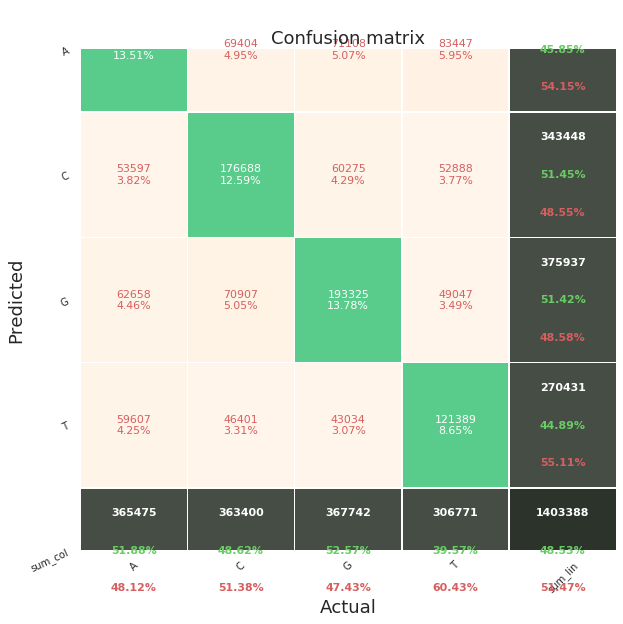

In [42]:
plot_confusion_matrix_from_data(label,prediction_lst,columns=['A','C','G','T'])

In [38]:
print(classification_report(label,prediction_lst, target_names=['A','C','G','T']))

              precision    recall  f1-score   support

           A       0.46      0.52      0.49    365475
           C       0.51      0.49      0.50    363400
           G       0.51      0.53      0.52    367742
           T       0.45      0.40      0.42    306771

    accuracy                           0.49   1403388
   macro avg       0.48      0.48      0.48   1403388
weighted avg       0.49      0.49      0.48   1403388

